In [1]:
! nvidia-smi

Sat Aug  8 06:09:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x

In [3]:
import os
import glob
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set()
import tensorflow as tf
from PIL import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
import zipfile
local_zip = '/content/drive/My Drive/project datasets/Malaria cell classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()
print("Done")

Done


In [6]:
base_dir = os.path.join('/content/Malaria cell classification/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [7]:
np.random.seed(42)

df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
r_label={"healthy":0,"malaria":1}

In [9]:
df['m_h']=df['label'].map(lambda rb:r_label[rb])

In [10]:
df.head()

,filename,label,m_h
0,/content/Malaria cell classification/cell_imag...,malaria,1
1,/content/Malaria cell classification/cell_imag...,malaria,1
2,/content/Malaria cell classification/cell_imag...,healthy,0
3,/content/Malaria cell classification/cell_imag...,healthy,0
4,/content/Malaria cell classification/cell_imag...,healthy,0


In [11]:
p=np.random.permutation(len(df))
train_up_to =int(len(df)*0.90)
train_idx=p[:train_up_to]
test_idx=p[train_up_to:]


In [12]:
train_up_to=int(train_up_to *0.9)
train_idx,valid_idx=train_idx[:train_up_to],train_idx[train_up_to:]

In [13]:
from PIL import Image
import albumentations as A
from albumentations import (Compose, OneOf, 
                            CLAHE, Flip, Rotate,GaussNoise,RandomBrightnessContrast,RandomGamma,HorizontalFlip,VerticalFlip)  

In [14]:
def aug(img):
  aug1 = A.Compose(
    [
      A.CLAHE(always_apply=True, p=1.0), 
      A.Rotate(always_apply = True,limit=(-360, 360), border_mode=3, p = 1.0),
      A.VerticalFlip(always_apply=True, p=1.0),
      A.HorizontalFlip(always_apply=True), 
      A.OneOf([
             A.Flip(), 
             A.Rotate()
             ], p=1.0),
      A.OneOf([
            A.GaussNoise(),
          
             ], p=0.9),
          A.OneOf([
            A.RandomBrightnessContrast(),
          
             ], p=0.9),
          A.OneOf([
            A.HorizontalFlip()
          
             ], p=0.9),
          A.OneOf([
            A.RandomGamma(),
          
             ], p=0.9),
    
    ])
  # np.random.seed(42)
  aug_img=aug1(image=img)['image']
  return aug_img
  

In [15]:
def aug1(img):
  aug2 = A.Compose(
    [
      A.CLAHE(always_apply=True, p=1.0)
     
    
    ])
  # np.random.seed(42)
  aug_img=aug2(image=img)['image']
  return aug_img
  

In [16]:
from keras.utils import to_categorical
def get_generator(df,indices,for_training=False,batch_size=16):
  images,mal=[],[]
  while True:
    for i in indices:
      r=df.iloc[i]
      files,l1=r['filename'],r['m_h']
      img=Image.open(files)
      img=img.resize((128,128))
      img=np.array(img)
      img=aug(img)/255.0
      images.append(img)
      mal.append(to_categorical(l1,2))
      if len(images)>=batch_size:
        a=np.array(images)
        b=np.array(mal)
        yield (a,b)
        images,mal=[],[]
    if not for_training:
      break

In [17]:
from keras.utils import to_categorical
def get_generator1(df,indices,for_training=False,batch_size=16):
  images,mal=[],[]
  while True:
    for i in indices:
      r=df.iloc[i]
      files,l1=r['filename'],r['m_h']
      img=Image.open(files)
      img=img.resize((128,128))
      img=np.array(img)
      img=aug1(img)/255.0
      images.append(img)
      mal.append(to_categorical(l1,2))
      if len(images)>=batch_size:
        a=np.array(images)
        b=np.array(mal)
        yield (a,b)
        images,mal=[],[]
    if not for_training:
      break

In [18]:
import keras
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPool2D,GlobalMaxPool2D,Dropout,SeparableConv2D,Dropout,GlobalAvgPool2D
from keras.models import Model

import tensorflow as tf

In [19]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Ignore the shape Warning
base_model = tf.keras.applications.DenseNet201(input_shape = (IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False



74842112/74836368 [==============================] - 1s 0us/step


In [20]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [21]:
unit1 =2560
inputs = Input(shape = (IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
#inputs = Input(shape = (256, 256, 3))

x = base_model(inputs)
# x=conv2d_block(x,bn=True,pool=True)
# # x=conv2d_block(x,filters=2048*2,bn=True)



bottleneck = GlobalAvgPool2D()(x)

x = Dense(units = unit1, activation = 'relu')(bottleneck)
mal= Dense(2, activation = 'sigmoid', name = 'mal')(x)

model = Model(inputs = [inputs], outputs=[mal])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 2560)              4917760   
_________________________________________________________________
mal (Dense)                  (None, 2)                 5122      
Total params: 23,244,866
Trainable params: 4,922,882
Non-trainable params: 18,321,984
_________________________________________________________________


# model

#1

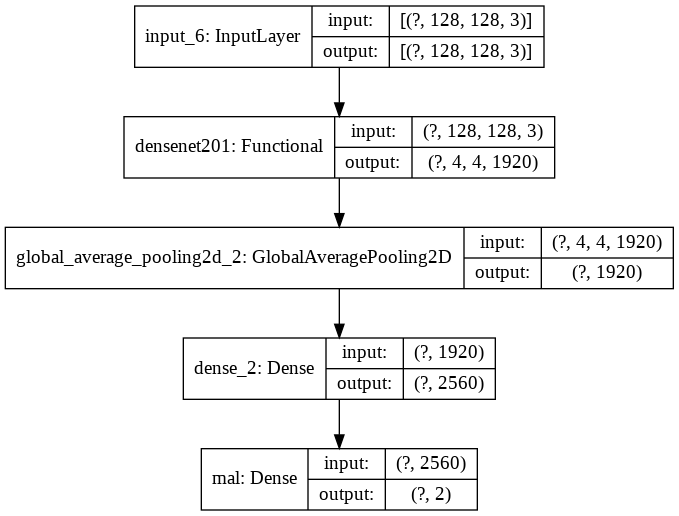

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

In [22]:
def lr_schedule(epoch):
   
    lr =0.005
    if epoch >15:
        lr *=2**-1
    elif epoch >12:
        lr *=2**(-1)
    elif epoch >8:
        lr *=2**(-1)
    elif epoch >5:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

In [24]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [ ]:
# optimiser=tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=True,
#     name="Adam"
# )
# bce_fn=tf.keras.losses.BinaryCrossentropy()
# model.compile(optimizer =optimiser , loss =bce_fn , metrics = ['accuracy','AUC'])

In [25]:
opt=tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)
bce_fn=tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=opt,
              loss=bce_fn,
              metrics=["accuracy","AUC"])

In [26]:
batch_size=64
valid_batch=64
train_gen=get_generator(df,train_idx,for_training=True,batch_size=batch_size)
valid_gen=get_generator1(df,valid_idx,for_training=True,batch_size=valid_batch)

In [27]:
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size)

Epoch 1/10
348/348 [==============================] - 179s 514ms/step - loss: 0.2370 - accuracy: 0.9177 - auc: 0.9672 - val_loss: 0.3177 - val_accuracy: 0.8783 - val_auc: 0.9502
Epoch 2/10
348/348 [==============================] - 177s 507ms/step - loss: 0.1684 - accuracy: 0.9400 - auc: 0.9816 - val_loss: 0.1874 - val_accuracy: 0.9276 - val_auc: 0.9777
Epoch 3/10
348/348 [==============================] - 177s 507ms/step - loss: 0.1580 - accuracy: 0.9443 - auc: 0.9836 - val_loss: 0.1995 - val_accuracy: 0.9276 - val_auc: 0.9767
Epoch 4/10
348/348 [==============================] - 179s 514ms/step - loss: 0.1517 - accuracy: 0.9471 - auc: 0.9849 - val_loss: 0.2482 - val_accuracy: 0.8935 - val_auc: 0.9632
Epoch 5/10
348/348 [==============================] - 177s 510ms/step - loss: 0.1487 - accuracy: 0.9462 - auc: 0.9856 - val_loss: 0.1677 - val_accuracy: 0.9391 - val_auc: 0.9811
Epoch 6/10
348/348 [==============================] - 177s 508ms/step - loss: 0.1459 - accuracy: 0.9485 - auc:

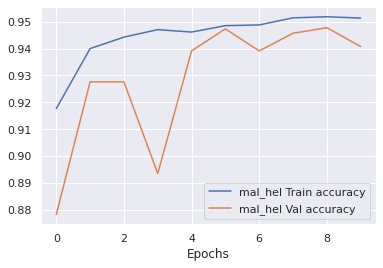

In [28]:
def  plot_train_history(history):
    fig= plt.plot( figsize=(20, 5))
    plt.plot(history.history['accuracy'], label='mal_hel Train accuracy')
    plt.plot(history.history['val_accuracy'], label='mal_hel Val accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plot_train_history(history)

In [29]:
test_gen = get_generator1(df, test_idx, for_training=False, batch_size=32)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//32)))

Instructions for updating:
Please use Model.evaluate, which supports generators.


{'accuracy': 0.9429506063461304,
 'auc': 0.9854171872138977,
 'loss': 0.15024520456790924}

In [31]:
test_gen = get_generator(df, test_idx, for_training=False, batch_size=32)
x_test, (r_b_true)= next(test_gen)
r_b_pred= model.predict_on_batch(x_test)

In [32]:
r_b_true=r_b_true.argmax(axis=-1)
r_b_pred=r_b_pred.argmax(axis=-1)

In [33]:
from sklearn.metrics import classification_report
print("Classification report for Malaria/Healthy")
print(classification_report(r_b_true,r_b_pred))

Classification report for Malaria/Healthy
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.92      0.96        12

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



In [34]:
label={0:'Healthy',1:'Malaria'}

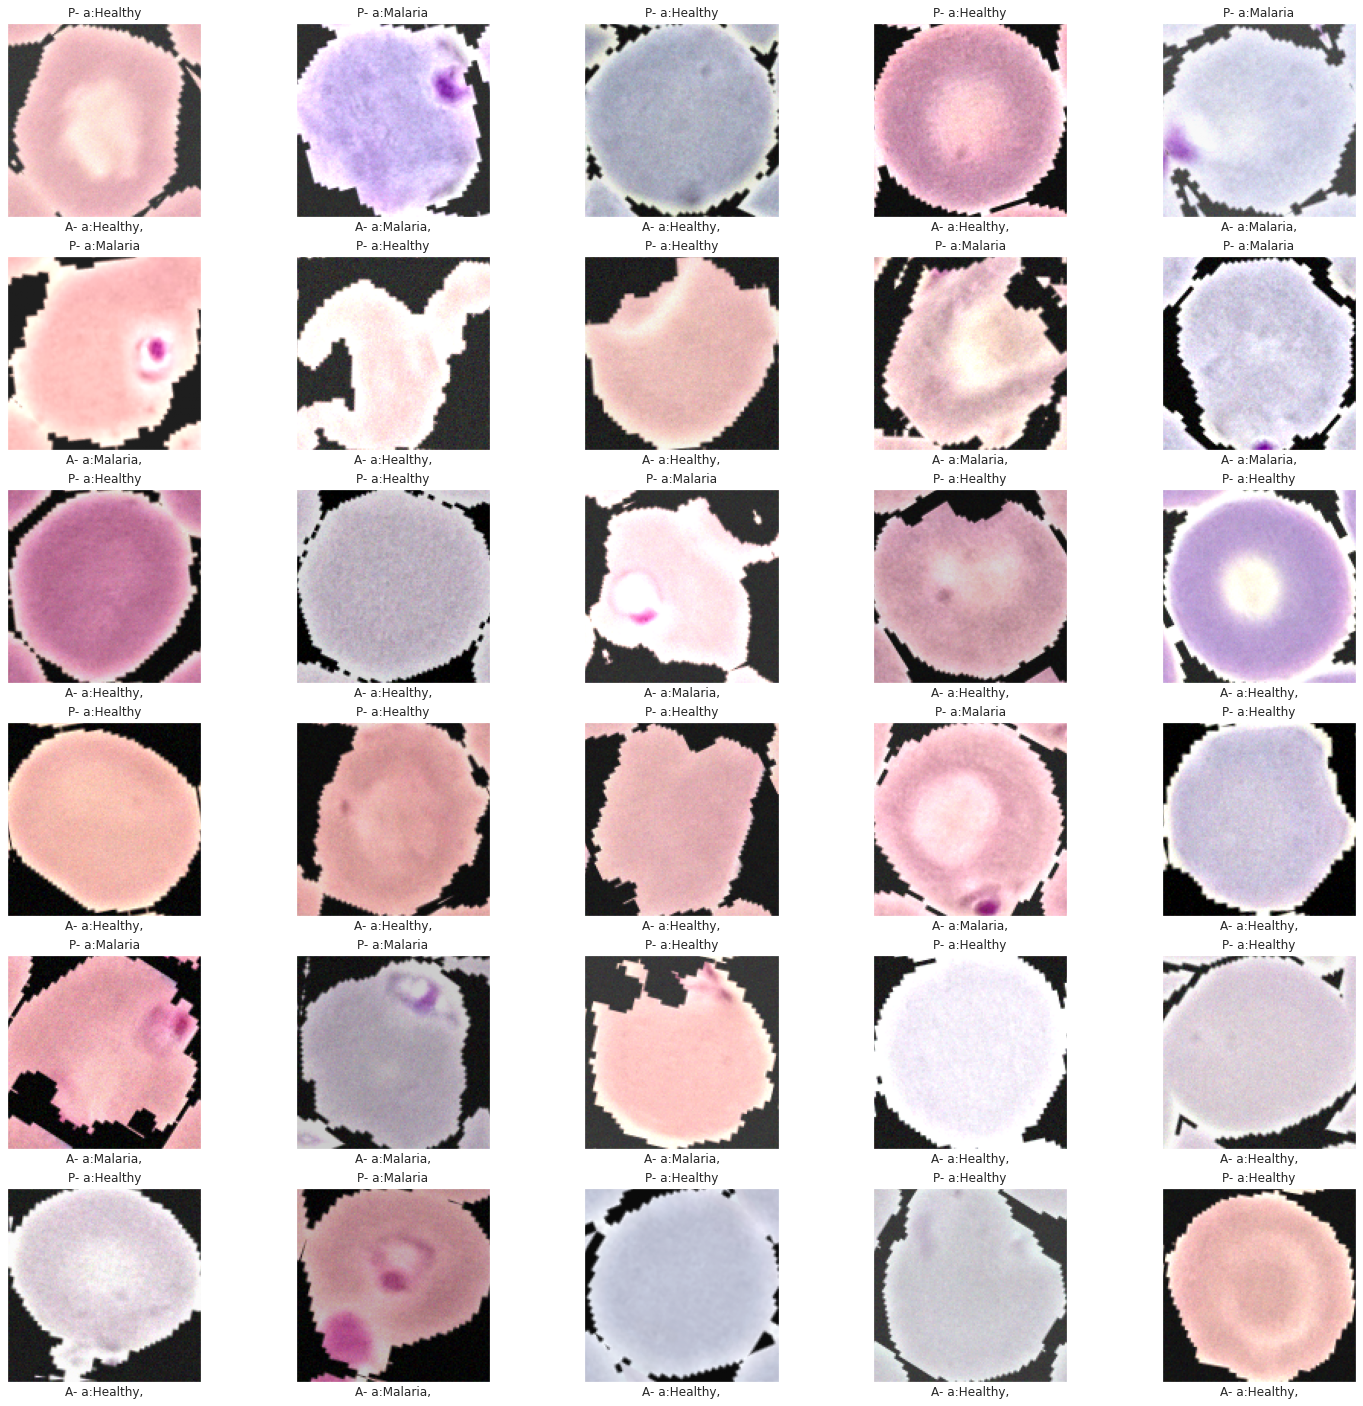

In [35]:
sns.set()
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('P- a:{}'.format(label[r_b_pred[img_idx]]))
    ax.set_xlabel('A- a:{},'.format(label[r_b_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
model.save('/content/drive/My Drive/MOdels/malaria.h5')